In [1]:
import csv
import os
import numpy as np
from get_data_at_location import get_data_at_location
from calculate_confusion_matrix import calculate_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import math
import xgboost

%matplotlib inline

n_folds = 5

data_dir = '/home/sohrob/Dropbox/Data/CS120/'

subjects = os.listdir(data_dir)

subjects = [subjects[0]]

print subjects

for subj in subjects:
    filename = data_dir + subj + '/eml.csv'
    if os.path.exists(filename):
        print filename
        loc = []
        lat_report = []
        lng_report = []
        t_report = []
        with open(filename) as file_in:
            data = csv.reader(file_in, delimiter='\t')
            for data_row in data:
                if data_row:
                    # reading location category (state)
                    loc_string = data_row[6]
                    loc_string = loc_string[1:len(loc_string)-1]
                    loc_string.split(',')
                    loc.append(loc_string)
                    
                    # reading lat. and long.
                    lat_report.append(float(data_row[2]))
                    lng_report.append(float(data_row[3]))
                    t_report.append(float(data_row[0]))
    file_in.close()
                       
    # looking into data between current and previous report
    filename = data_dir + subj + '/fus.csv'
    if os.path.exists(filename):
        with open(filename) as file_in:
            data_gps = csv.reader(file_in, delimiter='\t')
            t_gps = []
            lat_gps = []
            lng_gps = []
            for row_gps in data_gps:
                t_gps.append(float(row_gps[0]))
                lat_gps.append(float(row_gps[1]))
                lng_gps.append(float(row_gps[2]))
    file_in.close()

    #list_from = [abs(x-t_now) for x in t_gps]
    #ind_from = list_from.index(min(list_from))
    #list_to = [abs(x-t_prev) for x in t_gps]
    #ind_to = list_to.index(min(list_to))
    #t_prev = t_now
                    
    loc_uniq = list(set(loc))
    

['EW057EV']
/home/sohrob/Dropbox/Data/CS120/EW057EV/eml.csv


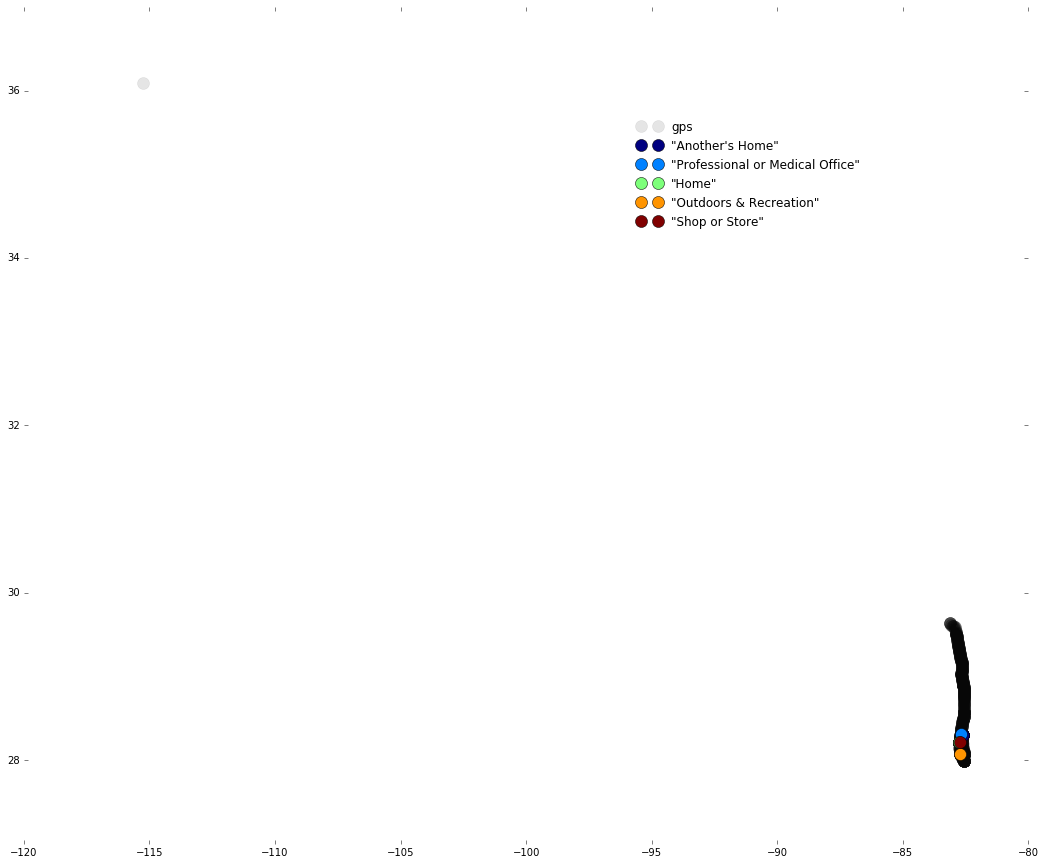

In [47]:
# spatial visualization
colors = plt.cm.jet(np.linspace(0,1,len(loc_uniq)))
plt.figure(figsize=(18,15))
plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(np.array(lng_gps),np.array(lat_gps),'ko',alpha=0.1, markersize=12)
for i in range(len(loc_uniq)):
    inds = loc.index(loc_uniq[i])
    plt.plot(np.array(lng_report[inds]), np.array(lat_report[inds]), 'o', color=colors[i], alpha=1, markersize=12)
plt.legend(['gps']+loc_uniq, frameon=False, loc='center left', bbox_to_anchor=(0.6, 0.8))
plt.box()

In [2]:
# creating feature and state matrices
t_prev = 0
feature = []
state = []
for i in range(len(t_report)):
    
    ft_row = []
    
    # location features
    #data_value = get_data_at_location(data_dir+subj, t_report[i], t_prev, lat_report[i], lng_report[i], 'fus')
    #for j in range(len(data_value)):
        #feature.append([float(data_value[j][1]), float(data_value[j][2])])
        #state.append(loc[i])
    
    # light features
    data_lgt = get_data_at_location(data_dir+subj, t_report[i], t_prev, lat_report[i], lng_report[i], 'lgt')
    lgt = data_lgt[:,1]
    lgt = lgt.astype(np.float)
    ft_row.append(np.mean(lgt))
    ft_row.append(np.std(lgt))

    # sound features
    data_aud = get_data_at_location(data_dir+subj, t_report[i], t_prev, lat_report[i], lng_report[i], 'aud')
    aud = data_aud[:,1]
    aud = aud.astype(np.float)
    ft_row.append(np.mean(aud))
    ft_row.append(np.std(aud))
        
    # screen features
    data_scr = get_data_at_location(data_dir+subj, t_report[i], t_prev, lat_report[i], lng_report[i], 'scr')
    if len(data_scr)>0:
        if len(data_scr[:,0])>=2:
            ft_row.append(len(data_scr[:,0])/(float(data_scr[len(data_scr)-1,0])-float(data_scr[0,0])))
        else:
            ft_row.append(0.0)
    else:
        ft_row.append(0.0)
                
    # activity features
    data_act = get_data_at_location(data_dir+subj, t_report[i], t_prev, lat_report[i], lng_report[i], 'act')
    n_still = 0
    if len(data_act)>0:
        for j in range(len(data_act[:,0])):
            n_still += (data_act[j,1]=='STILL')
        per_still = n_still/float(len(data_act[:,0]))
    else:
        per_still = 0
    ft_row.append(per_still)
        
    # general features
    ft_row.append(t_report[i]-t_prev)
    ft_row.append(((t_report[i]-t_prev)/2.0)%86400)
    
    # adding to feature vector
    feature.append(ft_row)
    state.append(loc[i])
    if i<len(t_report)-1:
        if t_report[i]!=t_report[i+1]:
            t_prev = t_report[i]


[1450205694.0]
[1450208317.0]
[1450205694.0]
[1450208317.0]
[1450205694.0]
[1450208317.0]
[1450205694.0]
[1450208317.0]
[1450150166.0, 1450172072.0, 1450180768.0, 1450210255.0, 1450218858.0]
[1450150637.0, 1450178936.0, 1450203724.0, 1450218134.0, 1450230223.0]
[1450150166.0, 1450172072.0, 1450180768.0, 1450210255.0, 1450218858.0]
[1450150637.0, 1450178936.0, 1450203724.0, 1450218134.0, 1450230223.0]
[1450150166.0, 1450172072.0, 1450180768.0, 1450210255.0, 1450218858.0]
[1450150637.0, 1450178936.0, 1450203724.0, 1450218134.0, 1450230223.0]
[1450150166.0, 1450172072.0, 1450180768.0, 1450210255.0, 1450218858.0]
[1450150637.0, 1450178936.0, 1450203724.0, 1450218134.0, 1450230223.0]
[1450230241.0, 1450308451.0]
[1450274959.0, 1450318160.0]
[1450230241.0, 1450308451.0]
[1450274959.0, 1450318160.0]
[1450230241.0, 1450308451.0]
[1450274959.0, 1450318160.0]
[1450230241.0, 1450308451.0]
[1450274959.0, 1450318160.0]
[1450276359.0, 1450295495.0]
[1450293105.0, 1450307197.0]
[1450276359.0, 1450295

In [3]:
# keeping only classes with more than 2 samples
feature = [s for (i,s) in enumerate(feature) if state.count(state[i])>=n_folds]
loc_uniq = [s for (i,s) in enumerate(loc_uniq) if state.count(s)>=n_folds]
state = [s for (i,s) in enumerate(state) if state.count(state[i])>=n_folds]

# converting feature list to matrix
feature = np.array(feature)

# concerting location categories to codes
le = preprocessing.LabelEncoder()
le.fit(state)
state_code = le.transform(state)


['"Home"', '"Work"', '"Food (Restaurant, Cafe)"', '"Shop or Store"']


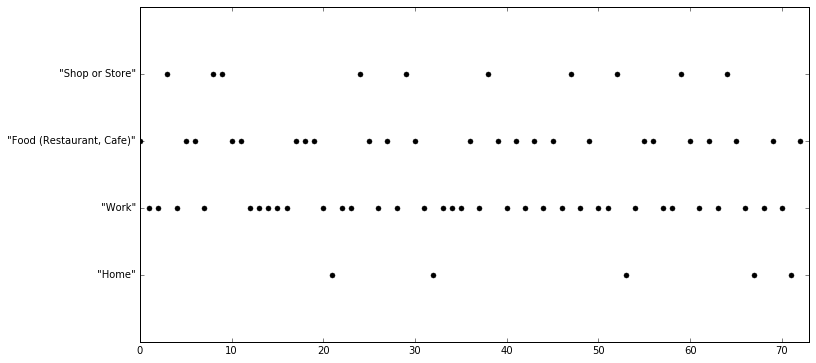

In [9]:
# temporal visualization
plt.figure(figsize=(12,6))
plt.plot(state_code,'.k',markersize=10)
plt.yticks(range(len(loc_uniq)), loc_uniq)
axes = plt.gca()
axes.set_xlim([0, len(state_code)])
axes.set_ylim([-1, len(loc_uniq)])
print loc_uniq

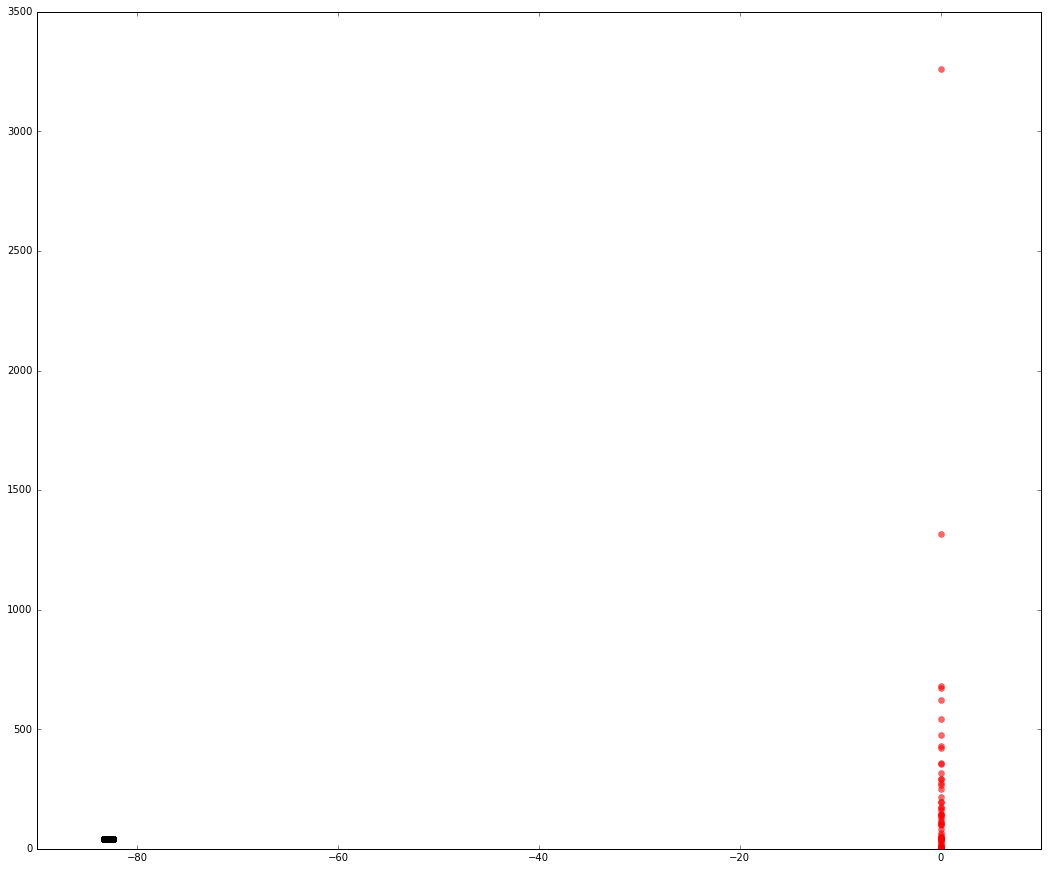

In [15]:
plt.figure(figsize=(18,15))
plt.plot(np.array(lng_gps),np.array(lat_gps),'k.', markersize=12, alpha=.6)
plt.plot(feature[:,1],feature[:,0],'r.', markersize=12, alpha=.6)
#plt.plot(np.array(lng_report),np.array(lat_report),'r.', markersize=12, alpha=.6)

([<matplotlib.axis.XTick at 0x7fd1e83e3fd0>,
 <a list of 7 Text xticklabel objects>)

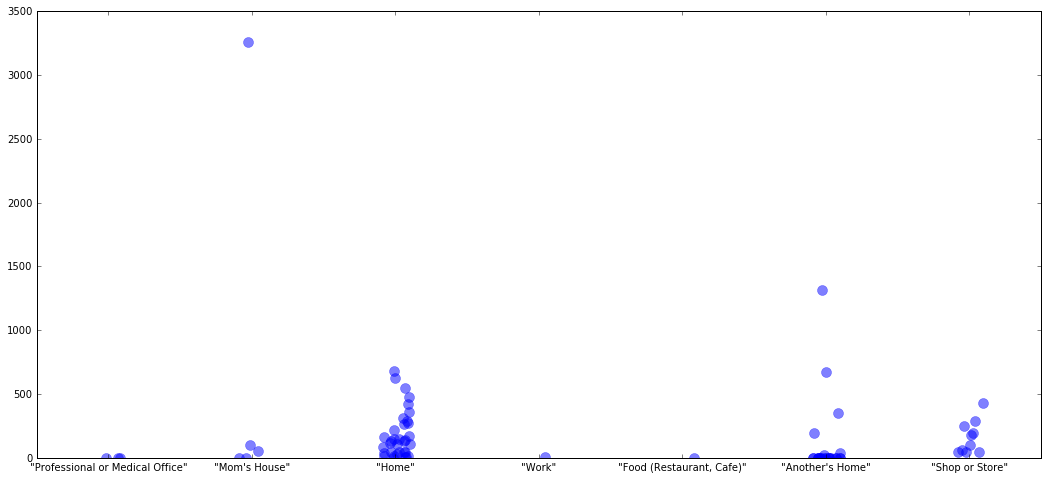

In [18]:
# distribution of features across locations
ft = 0
plt.figure(figsize=(18,8))
plt.plot(state_code+np.random.uniform(-.1,.1,len(state_code)), feature[:,ft],'.',markersize=20, alpha=.5)
axes = plt.gca()
axes.set_xlim([-.5, len(loc_uniq)-.5])
plt.xticks(range(len(loc_uniq)), loc_uniq)


In [4]:
#creating train and test sets
split = np.floor(state_code.size/2)
x_train = feature[0:split,:]
x_test = feature[(split+1):,:]
y_train = state_code[0:split]
y_test = state_code[(split+1):]

#train
gbm = xgboost.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(x_train, y_train)

#test
predictions = gbm.predict(x_test)

#print predictions
#print y_test
conf, roc_auc = calculate_confusion_matrix(predictions, y_test)
print conf
print roc_auc

#clf = RandomForestClassifier(n_estimators=100)
#scores = cross_val_score(clf, feature, state_code, cv=n_folds)
#print scores.mean()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


NameError: global name 'roc_auc' is not defined

In [5]:
print y_test
print np.zeros(5)

[1 3 2 1 2 1 2 1 2 1 3 1 2 1 1 3 0 1 2 2 1 1 3 2 1 2 1 3 2 1 0 1 2 1 0 2]
[ 0.  0.  0.  0.  0.]
